In [16]:
import os
import numpy as np
import pandas as pd
import pickle
import yaml
import json
import math
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score
import matplotlib.pyplot as plt
import sys
import os
sys.path.append(os.path.dirname(os.path.abspath('.')))
import s3fs
from data_import.bdd import PostGre_SQL_DB


secret=secret
fs = s3fs.S3FileSystem(client_kwargs={'endpoint_url': 'http://minio.ouest.innovation.insee.eu'},
                       key='ssplab', secret=secret)
bdd = PostGre_SQL_DB(fs=fs)

In [2]:
from script_runtime import load_pipeline_and_model, project

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# load model

In [3]:
training_dir = 'output'
conf_file = os.path.join(os.path.abspath(training_dir), 'config.yaml')
configs, cleaners, processes, model = load_pipeline_and_model(conf_file, for_runtime=True)

In [4]:
model.load_model(os.path.join(training_dir, 'model.h5'),
                 os.path.join(training_dir, 'dict_info.p'))

# load data

In [5]:
with open('cabbis_test.json') as f:
    cabbis_model_test = json.load(f)
with open('X_test.p', 'rb') as f:
    X_model_test = pickle.load(f)
with open('y_test.p', 'rb') as f:
    y_model_test = pickle.load(f)

In [6]:
len(cabbis_model_test), len(y_model_test)

(497900, 497900)

In [7]:
train_range, eval_range, y_train, y_eval = train_test_split(range(len(cabbis_model_test)), y_model_test, test_size=0.3, stratify=y_model_test)

cabbis_train = np.asarray(cabbis_model_test)[train_range]
X_train = X_model_test[train_range]

cabbis_eval = np.asarray(cabbis_model_test)[eval_range]
X_eval = X_model_test[eval_range]

# calculate threshold

In [8]:
predictions = model.predict(X_train)

In [9]:
nb_bis = 1400000
pct_non_codables = 0.15  # int(nb_bis * np.sum(y_train[:, 1]) / len(y_train))

precisions = []
recalls = []
nb_bis_found = []
nb_bis_flagged = []
points = list(range(50, 100))
for p in points:
    non_codables = predictions[:, 1] >= p / 100.
    precisions.append(precision_score(y_train[:, 1], non_codables))
    recalls.append(recall_score(y_train[:, 1], non_codables))
    nb_bis_found.append(recalls[-1] * pct_non_codables)
    nb_bis_flagged.append(nb_bis_found[-1] / precisions[-1])

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in double_scalars
  


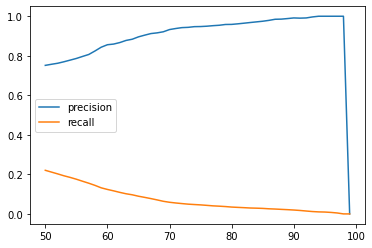

In [10]:
fig, ax = plt.subplots()  # Create a figure containing a single axes.
ax.plot(points, precisions, label='precision')  # Plot some data on the axes.
ax.plot(points, recalls, label='recall')  # Plot some data on the axes.
ax.legend()  # Add a legend.

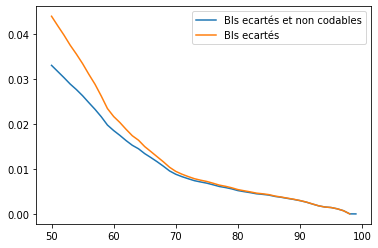

In [11]:
fig, ax = plt.subplots()  # Create a figure containing a single axes.
ax.plot(points, nb_bis_found, label='BIs ecartés et non codables')  # Plot some data on the axes.
ax.plot(points, nb_bis_flagged, label='BIs ecartés')  # Plot some data on the axes.
ax.legend()  # Add a legend.

# choose threshold

In [18]:
precision = 80

ind = [math.floor(v*100) for v in precisions].index(precision)
threshold = points[ind] / 100.

final_precision = precisions[ind]
final_recall = recalls[ind]
final_nb_bis_found = nb_bis_found[ind]
final_nb_bis_flagged = nb_bis_flagged[ind]

print(f'Pour une précision de {final_precision}, vous utiliser un seuil = {threshold}, et obtiendrez un recall de {final_recall}')
print(f'Pour une proportion estimée de {round(pct_non_codables*100, 2)}% de BI non codables, le système écartera {round(final_nb_bis_flagged*100, 2)}% des BI, dont {round(final_nb_bis_found*100, 2)}% effectivement non-codables')

print('')
print('')
predictions_eval = model.predict(X_eval)
non_codables_eval = predictions_eval[:, 1] >= threshold
precision_eval = precision_score(y_eval[:, 1], non_codables_eval)
recall_eval = recall_score(y_eval[:, 1], non_codables_eval)
nb_bis_found_eval = recall_eval * pct_non_codables
nb_bis_flagged_eval = nb_bis_found_eval / precision_eval

print(f"Sur les données d'evaluation, pour un seuil de {threshold}")
print(f'- précision: {precision_eval}, recall: {recall_eval}')
print(f'- Pour une proportion estimée de {round(pct_non_codables*100, 2)}% de BI non codables, le système écartera {round(nb_bis_flagged_eval*100, 2)}% des BI, dont {round(nb_bis_found_eval*100, 2)}% effectivement non-codables')

Pour une précision de 0.8065870910698497, vous utiliser un seuil = 0.57, et obtiendrez un recall de 0.15532286212914484
Pour une proportion estimée de 15.0% de BI non codables, le système écartera 2.89% des BI, dont 2.33% effectivement non-codables


Sur les données d'evaluation, pour un seuil de 0.57
- précision: 0.8, recall: 0.15971394517282478
- Pour une proportion estimée de 15.0% de BI non codables, le système écartera 2.99% des BI, dont 2.4% effectivement non-codables


## Explore false negative (non-codable not flagged)

In [19]:
false_negatives = np.array(range(len(predictions_eval)))[(predictions_eval[:, 1] < threshold) & (y_eval[:, 1] == 1)]

In [20]:
false_negative_cabbis = cabbis_eval[false_negatives]

In [43]:
sql = "SELECT * FROM rp_final_2019 WHERE cabbi IN ('"
sql += "','".join(false_negative_cabbis)
sql += "')"
df_fn = bdd.read_from_sql(sql)

In [44]:
df_fn['score_classif'] = predictions_eval[false_negatives, 1]

In [45]:
df_fn = df_fn[['cabbi','depcom_code', 'rs_x', 'ilt_x', 'vardompart_x',
               'numvoi_x', 'bister_x', 'typevoi_x', 'nomvoi_x', 'cpladr_x', 'actet_x',
               'clt_x', 'dlt_x', 'plt_x', 'profi_x', 'profs_x',
               'profa_x','siretm', 'siretc', 'siret_final','score_classif']]

In [46]:
df_fn.head()

,cabbi,depcom_code,rs_x,ilt_x,vardompart_x,numvoi_x,bister_x,typevoi_x,nomvoi_x,cpladr_x,...,clt_x,dlt_x,plt_x,profi_x,profs_x,profa_x,siretm,siretc,siret_final,score_classif
0,9300047541,94081,BSPP,1,None,0002,None,R,DE MEISSEN,None,...,None,None,None,None,SERGENT CHEF,None,None,None,None,0.083670
1,9300048902,97401,RECTORAT,None,None,None,None,None,None,None,...,None,None,None,None,PROFESSEUR,None,None,None,None,0.006459
2,9300049349,97401,ANCELOZ,2,1,None,None,None,None,None,...,SAINT-DENIS,974,None,None,CHEF DE CHANTIER,None,None,None,None,0.138403
3,9300049362,97401,OGEC,2,None,None,None,None,None,None,...,SAINTE-MARIE,None,None,None,FORMATRICE,None,None,None,None,0.142743
4,9300049604,97402,PFZ,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,0.198386


## Explore false positive (flagged but codable)

In [25]:
false_positives = np.array(range(len(predictions_eval)))[(predictions_eval[:, 1] >= threshold) & (y_eval[:, 1] == 0)]

In [26]:
false_positive_cabbis = cabbis_eval[false_positives]

In [47]:
sql = "SELECT * FROM rp_final_2019 WHERE cabbi IN ('"
sql += "','".join(false_positive_cabbis)
sql += "')"
df_fp = bdd.read_from_sql(sql)

In [48]:
df_fp['score_classif'] = predictions_eval[false_positives, 1]

In [51]:
df_fp = df_fp[['cabbi','depcom_code', 'rs_x', 'ilt_x', 'vardompart_x',
       'numvoi_x', 'bister_x', 'typevoi_x', 'nomvoi_x', 'cpladr_x', 'actet_x',
       'clt_x', 'dlt_x', 'plt_x', 'profi_x', 'profs_x',
       'profa_x','siretc', 'siretm','score_classif']]

In [52]:
df_fp.head()

,cabbi,depcom_code,rs_x,ilt_x,vardompart_x,numvoi_x,bister_x,typevoi_x,nomvoi_x,cpladr_x,actet_x,clt_x,dlt_x,plt_x,profi_x,profs_x,profa_x,siretc,siretm,score_classif
0,9300061764,97408,None,None,None,None,None,None,None,None,TNSR,LA POSSESSION,None,None,None,CONDUCTEUR D ENGIN,None,None,79313781100014,0.666219
1,9300096468,97416,None,1,None,None,None,None,MAIRIE MART VERS LES BAS,None,None,None,None,None,None,AGENT TECHNIQUE,EMPLOYE COMMUNAL,None,21974016400013,0.655407
2,9300190363,97213,MINISTERE DE LA DEFENSE,2,None,None,None,None,DESAIX,None,MILITAIRE,F DE F,972,None,None,MILITAIRE,None,13001005100311,None,0.688163
3,9300223611,97302,ARMEE,1,None,None,None,None,None,None,DEFENSE,None,None,None,None,MILITAIRE,None,47784205800018,None,0.570135
4,9300283931,50195,None,1,None,None,None,None,LA PIHANNIERE,None,AGRICULTRICE,None,None,None,None,None,None,None,39759388000016,0.639157


# save threshold

In [119]:
configs['decision_threshold'] = threshold
with open(conf_file, "w") as f:
    yaml.dump(configs, f)